(assignment09_solution)=

# Assignment #9 (demo). Time series analysis. Solution

<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg" />

**<center>[mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course** </center><br>

Author: Mariya Mansurova, Analyst & developer in Yandex.Metrics team. Translated by Ivan Zakharov, ML enthusiast. <br>This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

**Same assignment as a [Kaggle Notebook](https://www.kaggle.com/kashnitsky/a9-demo-time-series-analysis) + [solution](https://www.kaggle.com/kashnitsky/a9-demo-time-series-analysis-solution).**

**In this assignment, we are using Prophet and ARIMA to analyze the number of views for a Wikipedia [page](https://en.wikipedia.org/wiki/Machine_learning) on Machine Learning.**

**Fill cells marked with "Your code here" and submit your answers to the questions through the [web form](https://docs.google.com/forms/d/1UYQ_WYSpsV3VSlZAzhSN_YXmyjV7YlTP8EYMg8M8SoM/edit).**

In [1]:
import warnings

warnings.filterwarnings("ignore")
import os

import numpy as np
import pandas as pd
import requests
from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

print(__version__)  # need 1.9.0 or greater
init_notebook_mode(connected=True)


def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

5.12.0


## Data preparation

In [2]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

In [3]:
df = pd.read_csv(DATA_PATH + "wiki_machine_learning.csv", sep=" ")
df = df[df["count"] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [4]:
df.shape

(383, 7)

## Predicting with FB Prophet
We will train at first 5 months and predict the number of trips for June.

In [5]:
df.date = pd.to_datetime(df.date)

In [6]:
plotly_df(df.set_index("date")[["count"]])

In [7]:
from prophet import Prophet

In [8]:
predictions = 30

df = df[["date", "count"]]
df.columns = ["ds", "y"]
df.tail()

,ds,y
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389
372,2016-01-20,3559


In [9]:
train_df = df[:-predictions].copy()

In [10]:
m = Prophet()
m.fit(train_df);

19:24:37 - cmdstanpy - INFO - Chain [1] start processing


19:24:37 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
future = m.make_future_dataframe(periods=predictions)
future.tail()

,ds
378,2016-01-16
379,2016-01-17
380,2016-01-18
381,2016-01-19
382,2016-01-20


In [12]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
378,2016-01-16,2980.502288,1709.051748,2516.865559,2961.861802,3000.423442,-861.703627,-861.703627,-861.703627,-861.703627,-861.703627,-861.703627,0.0,0.0,0.0,2118.798661
379,2016-01-17,2985.922335,1821.854733,2652.506053,2966.326000,3006.835366,-720.722254,-720.722254,-720.722254,-720.722254,-720.722254,-720.722254,0.0,0.0,0.0,2265.200080
380,2016-01-18,2991.342382,2879.281271,3674.398219,2970.529062,3013.698766,281.347221,281.347221,281.347221,281.347221,281.347221,281.347221,0.0,0.0,0.0,3272.689603
381,2016-01-19,2996.762429,3125.805853,3942.308710,2973.921776,3020.341676,541.446780,541.446780,541.446780,541.446780,541.446780,541.446780,0.0,0.0,0.0,3538.209209
382,2016-01-20,3002.182476,3056.404356,3858.669880,2977.669387,3027.190462,425.562221,425.562221,425.562221,425.562221,425.562221,425.562221,0.0,0.0,0.0,3427.744697


**<font color='red'>Question 1:</font>** What is the prediction of the number of views of the wiki page on January 20? Round to the nearest integer.

- 4947
- 3426 **[+]**
- 5229
- 2744

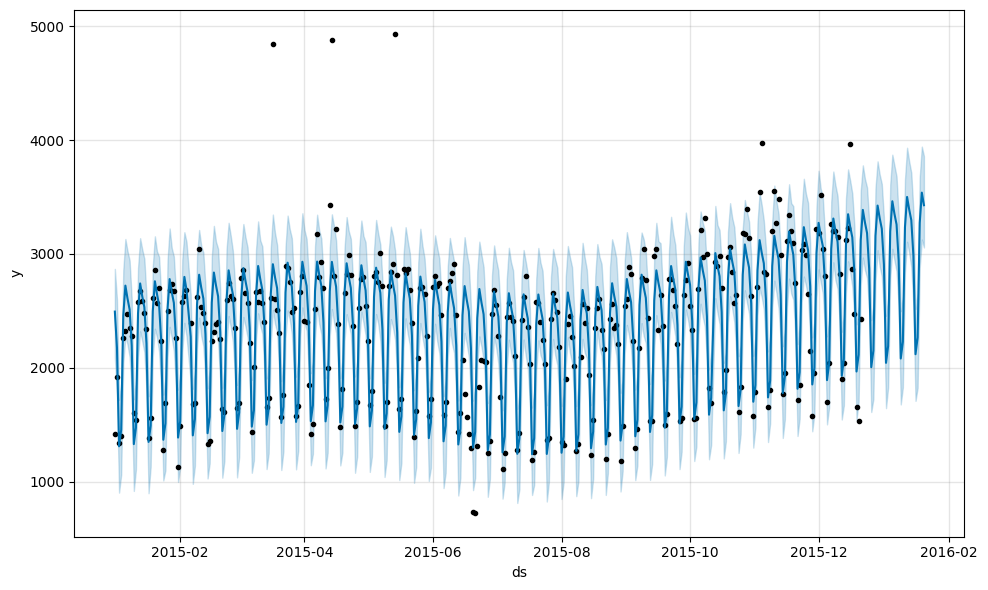

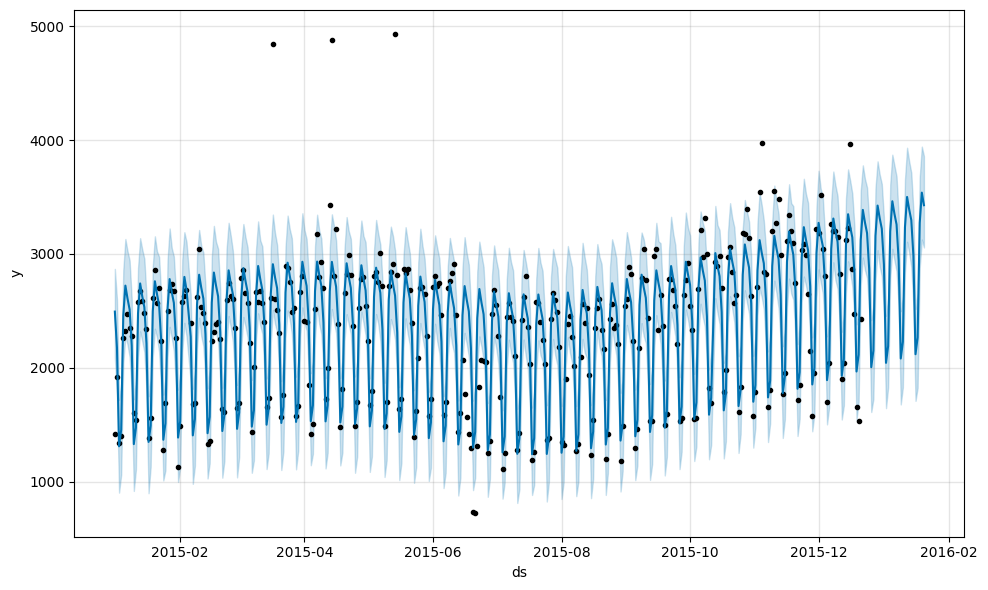

In [13]:
m.plot(forecast)

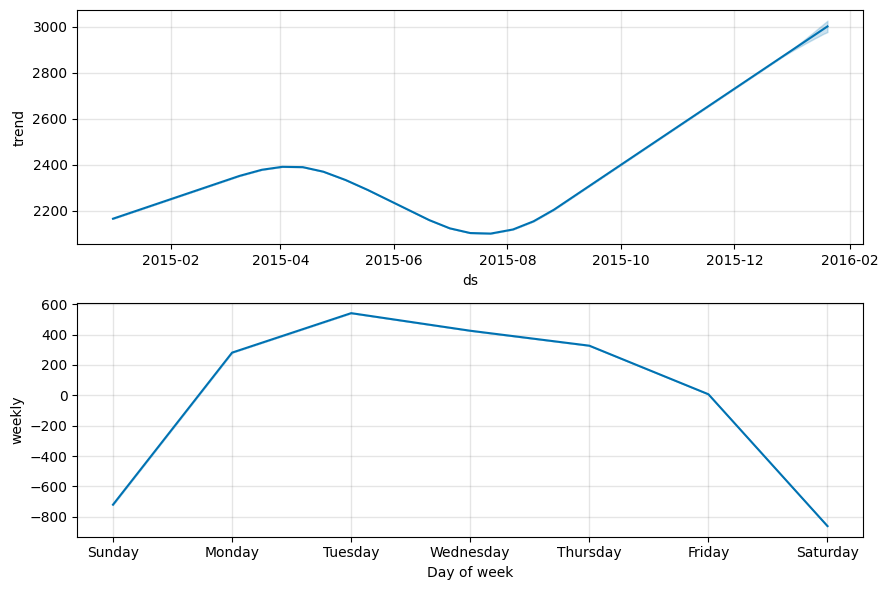

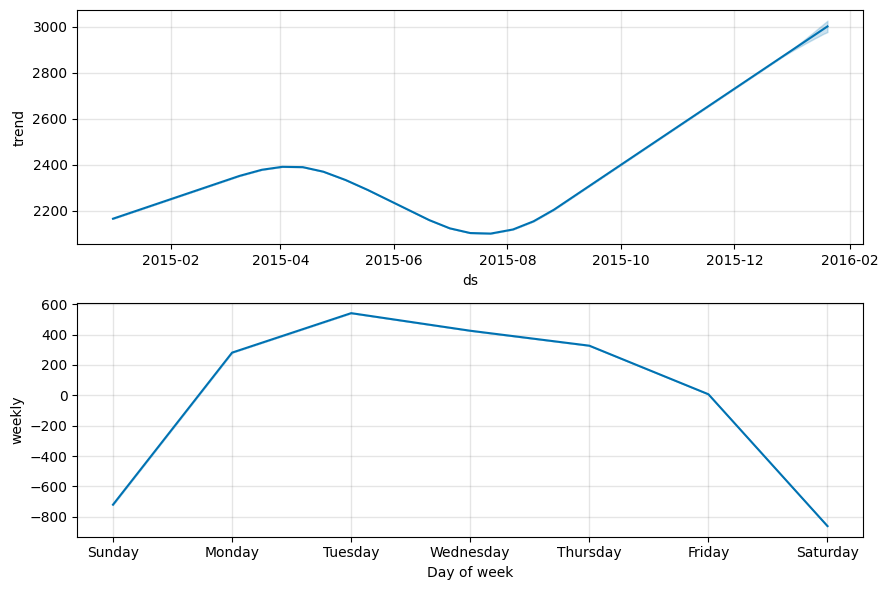

In [14]:
m.plot_components(forecast)

In [15]:
cmp_df = forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]].join(
    df.set_index("ds")
)

In [16]:
cmp_df["e"] = cmp_df["y"] - cmp_df["yhat"]
cmp_df["p"] = 100 * cmp_df["e"] / cmp_df["y"]
print("MAPE = ", round(np.mean(abs(cmp_df[-predictions:]["p"])), 2))
print("MAE = ", round(np.mean(abs(cmp_df[-predictions:]["e"])), 2))

MAPE =  34.55
MAE =  600.81


Estimate the quality of the prediction with the last 30 points.

**<font color='red'>Question 2:</font> What is MAPE equal to?**

- 34.5 **[+]**
- 42.42
- 5.39
- 65.91

**<font color='red'>Question 3:</font> What is MAE equal to?**

- 355
- 4007
- 600 **[+]**
- 903

## Predicting with ARIMA

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

plt.rcParams["figure.figsize"] = (15, 10)

**<font color='red'>Question 4:</font> Let's verify the stationarity of the series using the Dickey-Fuller test. Is the series stationary? What is the p-value?**

- Series is stationary, p_value = 0.107
- Series is not stationary, p_value = 0.107 **[+]**
- Series is stationary, p_value = 0.001
- Series is not stationary, p_value = 0.001

Dickey-Fuller test: p=0.107392


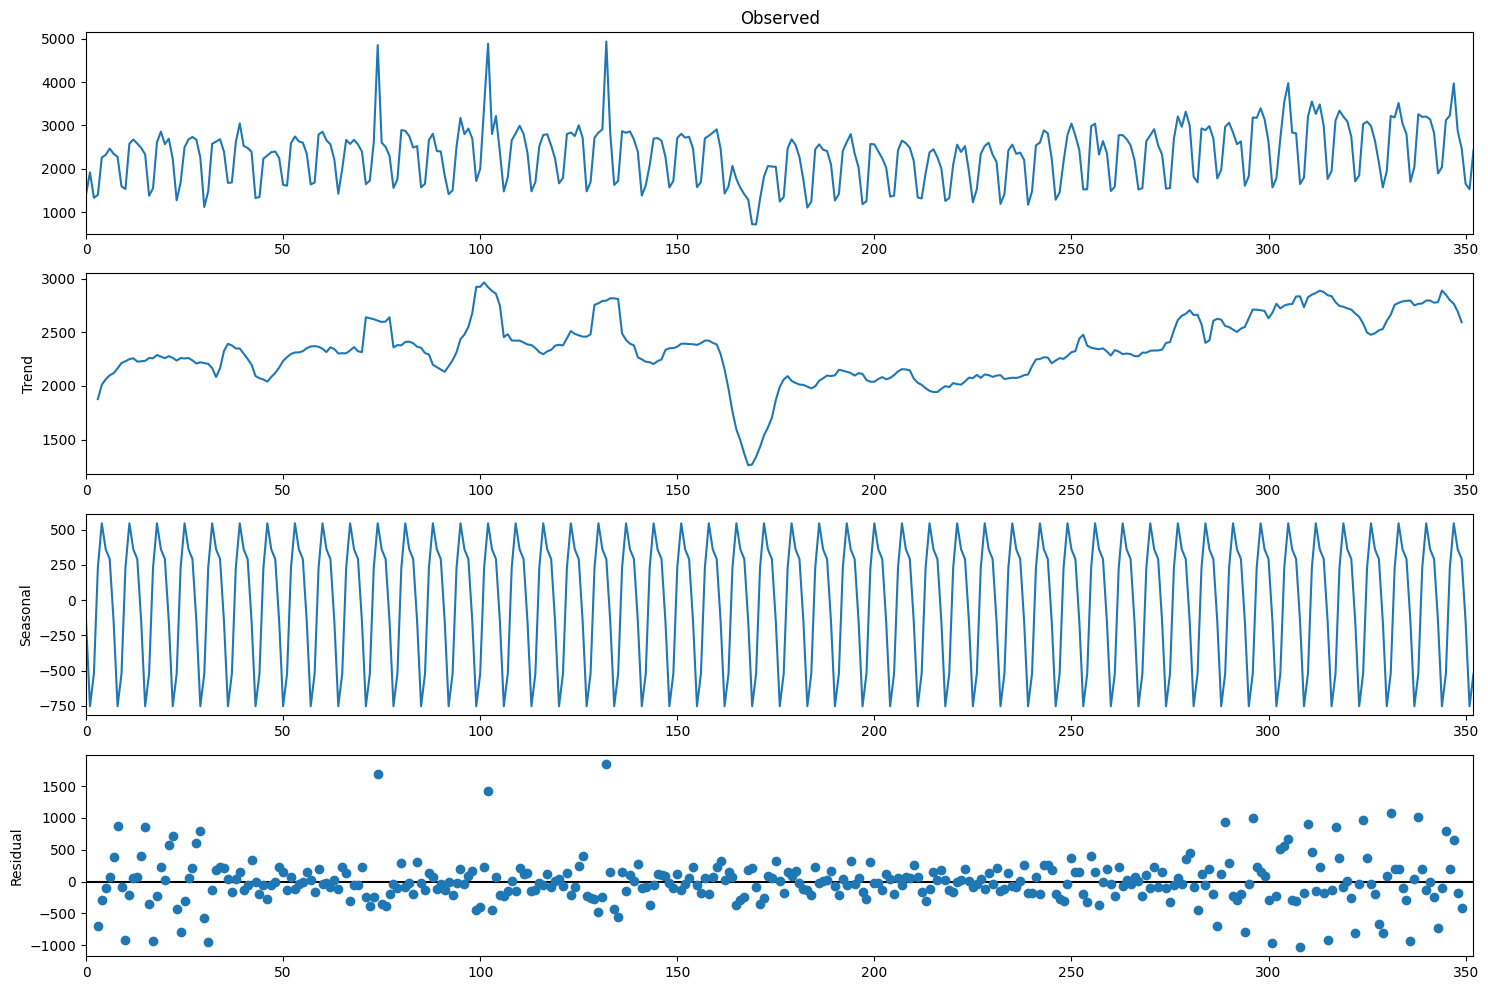

In [18]:
sm.tsa.seasonal_decompose(train_df["y"].values, period=7).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df["y"])[1])

But the seasonally differentiated series will already be stationary.

In [19]:
train_df.set_index("ds", inplace=True)

Dickey-Fuller test: p=0.000000


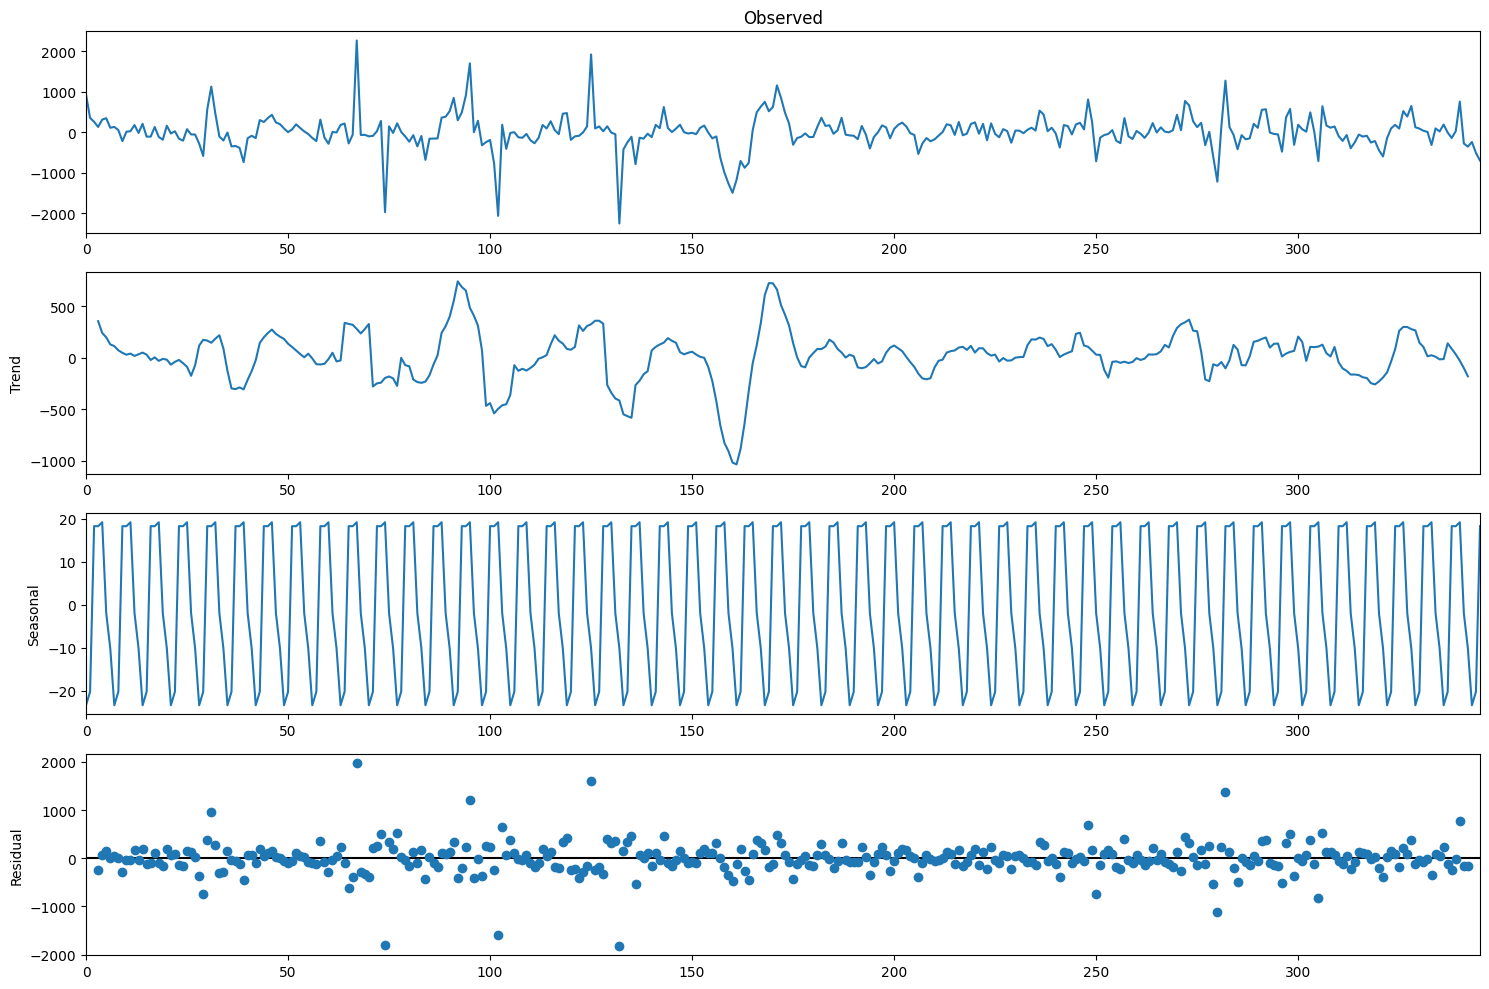

In [20]:
train_df["y_diff"] = train_df.y - train_df.y.shift(7)
sm.tsa.seasonal_decompose(train_df.y_diff[7:].values, period=7).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df.y_diff[8:])[1])

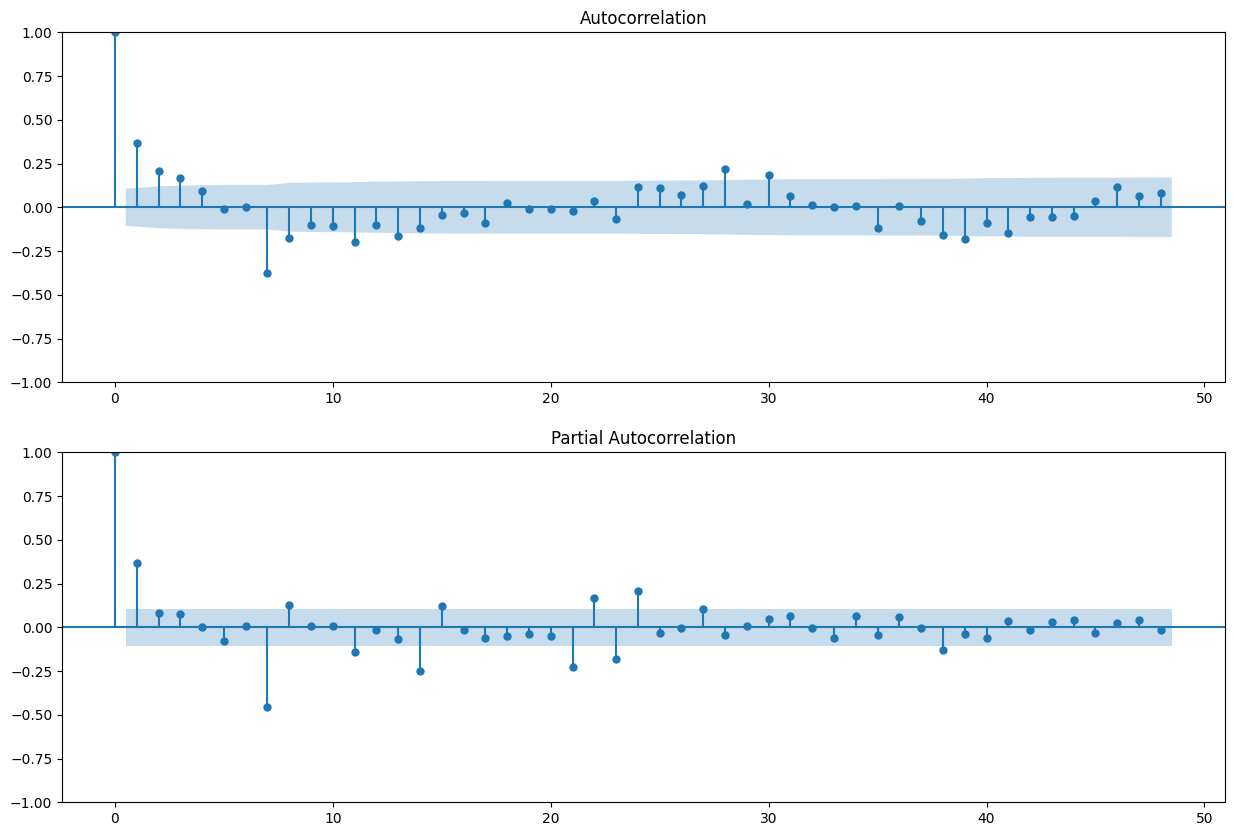

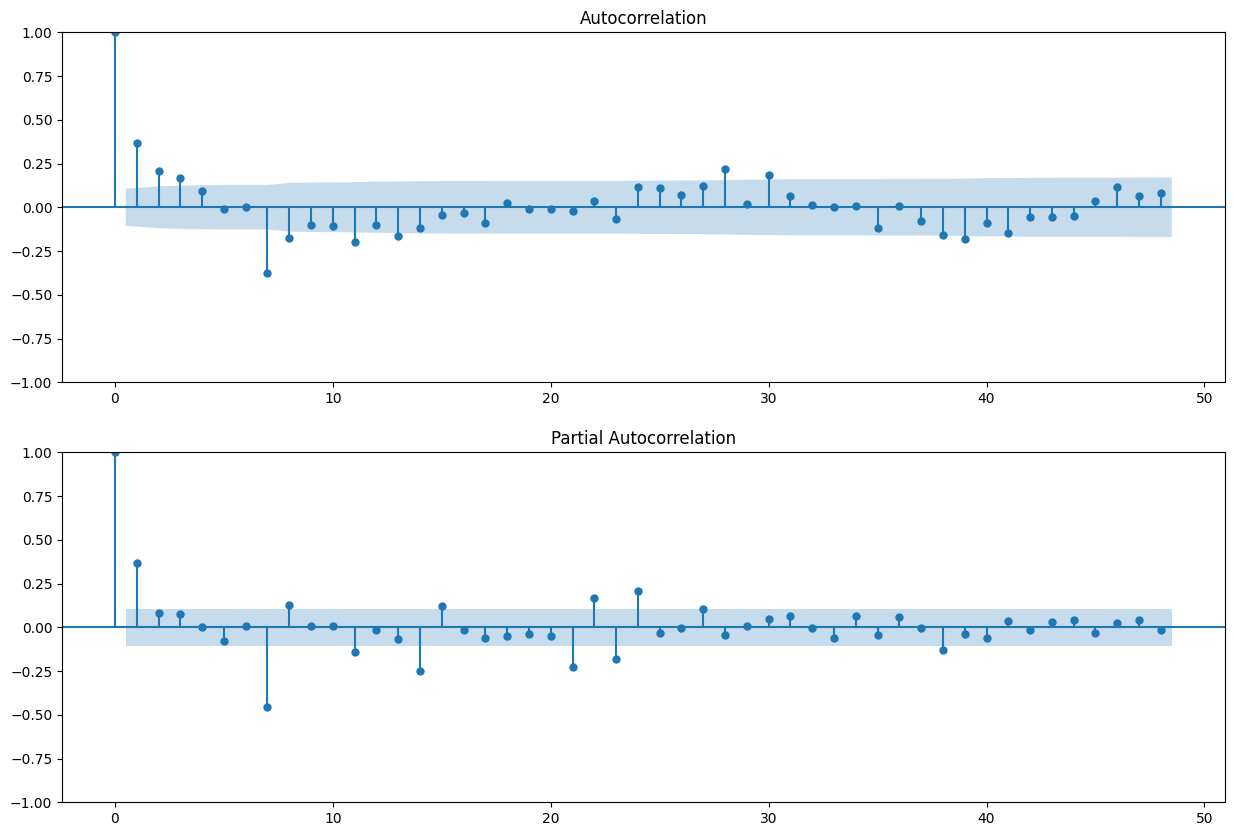

In [21]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

Initial values:
* Q = 1
* q = 3
* P = 3
* p = 1

In [22]:
ps = range(0, 2)
ds = range(0, 2)
qs = range(0, 4)
Ps = range(0, 4)
Ds = range(0, 3)
Qs = range(0, 2)

In [23]:
from itertools import product

parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
len(parameters_list)

384

In [24]:
%%time
import warnings

from tqdm.notebook import tqdm

results1 = []
best_aic = float("inf")
warnings.filterwarnings("ignore")

for param in tqdm(parameters_list):
    # try except is necessary, because on some sets of parameters the model can not be trained
    try:
        model = sm.tsa.statespace.SARIMAX(
            train_df["y"],
            order=(param[0], param[1], param[2]),
            seasonal_order=(param[3], param[4], param[5], 7),
            # train the model as is even if that would lead to a non-stationary / non-invertible model
            # see https://github.com/statsmodels/statsmodels/issues/6225 for details
        ).fit(disp=-1)

    except (ValueError, np.linalg.LinAlgError):
        continue

    aic = model.aic
    # save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results1.append([param, model.aic])

  0%|          | 0/384 [00:00<?, ?it/s]

CPU times: user 25min 14s, sys: 4min 34s, total: 29min 49s
Wall time: 5min 33s


In [25]:
result_table1 = pd.DataFrame(results1)
result_table1.columns = ["parameters", "aic"]
print(result_table1.sort_values(by="aic", ascending=True).head())

             parameters          aic
165  (0, 1, 2, 3, 2, 1)  4961.632628
332  (1, 1, 1, 3, 2, 1)  4962.829123
380  (1, 1, 3, 3, 2, 1)  4965.688340
189  (0, 1, 3, 3, 2, 1)  4969.534607
213  (1, 0, 0, 3, 2, 1)  4973.212241


If we consider the variants proposed in the form:

In [26]:
result_table1[
    result_table1["parameters"].isin(
        [(1, 0, 2, 3, 1, 0), (1, 1, 2, 3, 2, 1), (1, 1, 2, 3, 1, 1), (1, 0, 2, 3, 0, 0)]
    )
].sort_values(by="aic")

,parameters,aic
356,"(1, 1, 2, 3, 2, 1)",4988.977318
354,"(1, 1, 2, 3, 1, 1)",5019.555903
257,"(1, 0, 2, 3, 1, 0)",5022.312524
255,"(1, 0, 2, 3, 0, 0)",5183.824614


Now do the same, but for the series with Box-Cox transformation.

In [27]:
import scipy.stats

train_df["y_box"], lmbda = scipy.stats.boxcox(train_df["y"])
print("The optimal Box-Cox transformation parameter: %f" % lmbda)

The optimal Box-Cox transformation parameter: 0.732841


In [28]:
results2 = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    # try except is necessary, because on some sets of parameters the model can not be trained
    try:
        model = sm.tsa.statespace.SARIMAX(
            train_df["y_box"],
            order=(param[0], param[1], param[2]),
            seasonal_order=(param[3], param[4], param[5], 7),
            # train the model as is even if that would lead to a non-stationary / non-invertible model
            # see https://github.com/statsmodels/statsmodels/issues/6225 for details
            enforce_stationary=False,  
            enforce_invertibility=False  
        ).fit(disp=-1)

    except (ValueError, np.linalg.LinAlgError):
        continue

    aic = model.aic
    # save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results2.append([param, model.aic])

warnings.filterwarnings("default")

  0%|          | 0/384 [00:00<?, ?it/s]

In [29]:
result_table2 = pd.DataFrame(results2)
result_table2.columns = ["parameters", "aic"]
print(result_table2.sort_values(by="aic", ascending=True).head())

             parameters          aic
65   (0, 0, 2, 3, 0, 0)    12.000000
66   (0, 0, 2, 3, 0, 1)    14.000000
261  (1, 0, 2, 3, 2, 1)  3528.568461
285  (1, 0, 3, 3, 2, 1)  3529.820329
213  (1, 0, 0, 3, 2, 1)  3530.231534


If we consider the variants proposed in the form:

In [30]:
result_table2[
    result_table2["parameters"].isin(
        [(1, 0, 2, 3, 1, 0), (1, 1, 2, 3, 2, 1), (1, 1, 2, 3, 1, 1), (1, 0, 2, 3, 0, 0)]
    )
].sort_values(by="aic")

,parameters,aic
357,"(1, 1, 2, 3, 2, 1)",3544.416192
258,"(1, 0, 2, 3, 1, 0)",3556.880030
355,"(1, 1, 2, 3, 1, 1)",3557.894203
256,"(1, 0, 2, 3, 0, 0)",3687.195117


**Next, we turn to the construction of the SARIMAX model (`sm.tsa.statespace.SARIMAX`).<br> <font color='red'>Question 5:</font> What parameters are the best for the model according to the `AIC` criterion?**

- D = 1, d = 0, Q = 0, q = 2, P = 3, p = 1
- D = 2, d = 1, Q = 1, q = 2, P = 3, p = 1 **[+]**
- D = 1, d = 1, Q = 1, q = 2, P = 3, p = 1
- D = 0, d = 0, Q = 0, q = 2, P = 3, p = 1

Let's look at the forecast of the best AIC model.

**Note:** any AIC below 3000 is suspicious, probably caused by non-convergence with MLE optimization, we'll pick the 3rd-best model in terms of AIC to visualize predictions.

In [31]:
best_model = sm.tsa.statespace.SARIMAX(
    train_df["y_box"],
    order=(1, 0, 2),
    seasonal_order=(3, 2, 1, 7),
    enforce_stationary=False,  
    enforce_invertibility=False  
).fit(disp=-1)

/Users/kashnitskiyy/Library/Caches/pypoetry/virtualenvs/mlcourse-ai-hdQs52Zw-py3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



/Users/kashnitskiyy/Library/Caches/pypoetry/virtualenvs/mlcourse-ai-hdQs52Zw-py3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [32]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               y_box   No. Observations:                  353
Model:             SARIMAX(1, 0, 2)x(3, 2, [1], 7)   Log Likelihood               -1756.284
Date:                             Fri, 03 Feb 2023   AIC                           3528.568
Time:                                     19:35:13   BIC                           3559.176
Sample:                                          0   HQIC                          3540.766
                                             - 353                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8412      0.110      7.660      0.000       0.626       1.056
ma.L1         -0.3666      

Student's test: p=0.118890
Dickey-Fuller test: p=0.000000


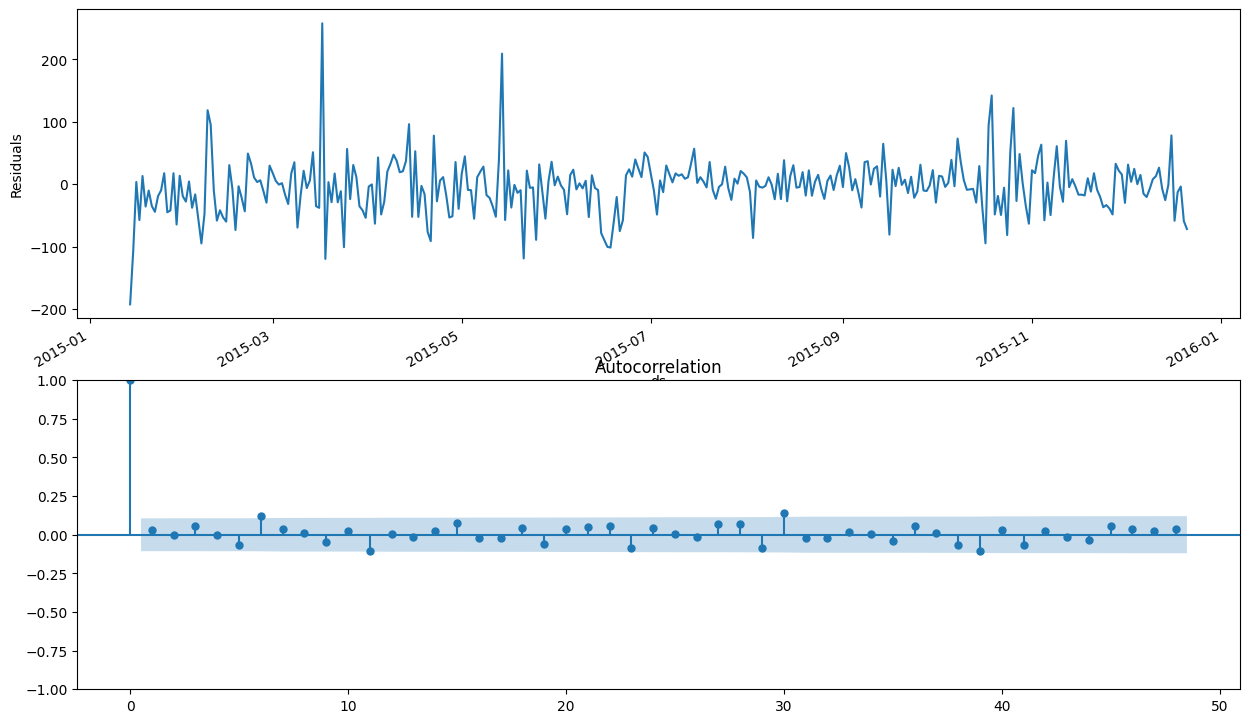

In [33]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u"Residuals")

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student's test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [34]:
def invboxcox(y, lmbda):
    # reverse Box Cox transformation
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)

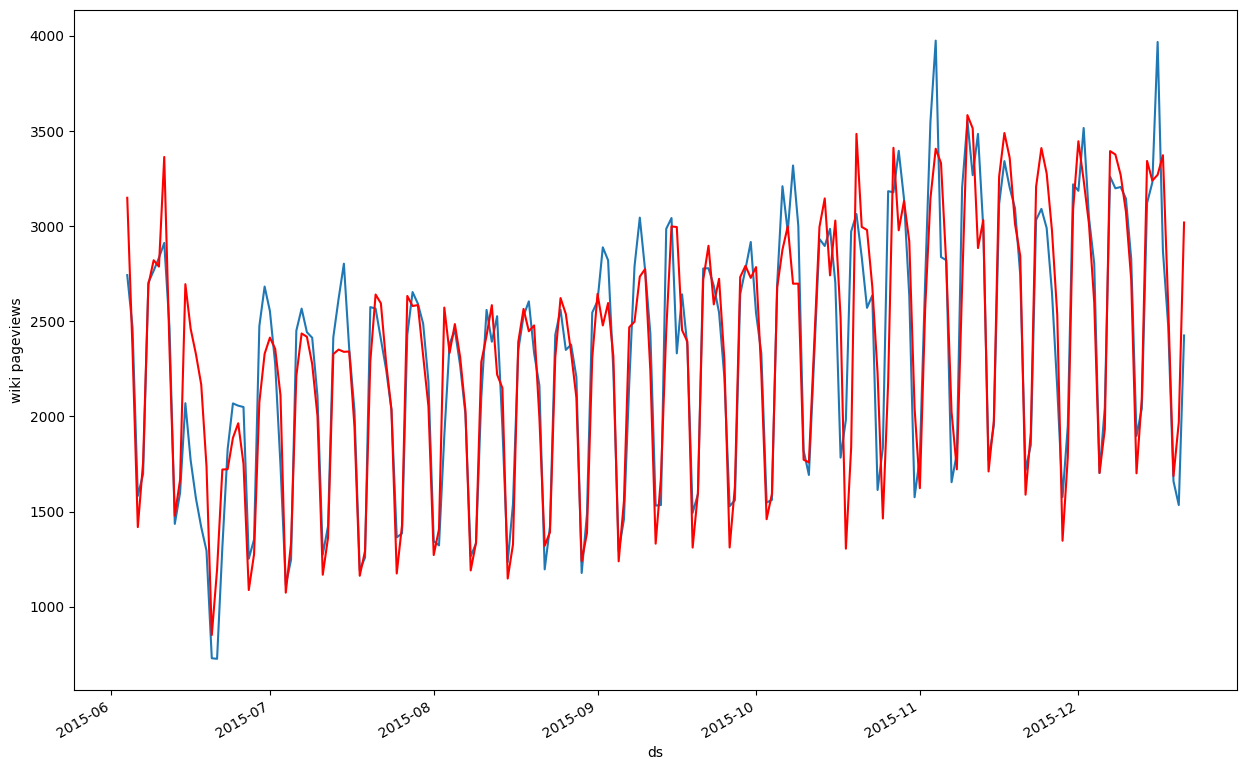

In [35]:
train_df["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)

train_df.y.tail(200).plot()
train_df.arima_model[13:].tail(200).plot(color="r")
plt.ylabel("wiki pageviews");